# 2.8 Spectral Transforms


## Introduction
In geosciences, much of the data we deal with—whether it’s seismic waves, ocean tides, or atmospheric pressure variations—comes in the form of time series. These signals often contain information at multiple frequencies, and using a simple time-domain analysis may obscure important features of the data. 


Spectrograms are powerful tools for analyzing and visualizing the frequency content of time-series data. A spectrogram represents the spectral density of a signal as it changes over time. It is especially useful in geoscientific applications where signals can be non-stationary, i.e., their frequency content changes over time. Examples include:

* ***Earthquake seismology***: where both low and high-frequency signals are relevant at different stages of an event.
* ***Atmospheric science***: where periodic patterns such as tides and waves have distinct frequency components.
* ***Remote sensing***: where different processes, such as soil moisture fluctuations, can exhibit characteristic frequencies over time.

**Why spectrograms are important**
* ***Time-frequency Analysis***R: Spectrograms allow us to see how the frequency content of a signal evolves over time, making them suitable for studying non-stationary data.
* ***Feature Extraction***R: Spectrograms highlight transient events and long-duration patterns, making them ideal for detecting and characterizing geophysical phenomena like earthquakes, landslides, or atmospheric waves.
* ***Multiscale Analysis***R: Many natural processes operate at different time scales. Spectrograms allow us to visualize and extract features across these scales.
* ***Visualization***R: They offer a compact and interpretable visualization of complex time-series data.


In this section, we will transform the data by projecting it onto basis of functions. The two most used transforms as the **Fourier** and the **wavelet** transforms.

::warning::
Filtering any data needs to be done carefully and potential artefact due to filtering can lead to complete misenterpretation. Awareness for **filtering artefacts** is very critical for proper scientific investigation. Pitfalls might be
* Not all filters preserve causality: some  signals may appear **before events** and be misinterpreted as *precursors*.
* Filtering over data gaps brings high frequency artefacts
* Edges effects in filtering times series are difficult to mitigate


The lecture covers several levels and methods for transforming data.

1. Fourier Transforms: 1D  [**Level 1**]
2. Fourier Transforms: 2D  [**Level 3**]
3. Spectrograms [**Level 2**]
4. Wavelet Transforms [**Level 3**]


In [58]:
# Import modules for seismic data and feature extraction

import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import scipy
import scipy.signal as signal


# seismic python toolbox
import obspy
import obspy.clients.fdsn.client as fdsn
from obspy import UTCDateTime 



We will first download data. The seismic data from Puget Sound for a large M8.2 earthquake that happened in Alaska, July 29, 2021.

In [59]:
# Download seismic data
network = 'UW'
station = 'RATT'
channel = 'HHZ'# this channel gives a low frequency, 1Hz signal.
Tstart = UTCDateTime(2021,7,29,6,15)
Tend = Tstart+7200# UTCDateTime(year=2022, month=10, day=8)
fdsn_client = fdsn.Client('IRIS') # client to query the IRIS DMC server

# call to download the specific data: earthquake waveforms
Z = fdsn_client.get_waveforms(network=network, station=station, location='--', channel=channel, starttime=Tstart, \
    endtime=Tend, attach_response=True)
# basic pre-processing: merge all data if there is gaps, detrend, taper,
#  remove the seismic instrumental response to go from the digitizer units to ground motion (velocity) units.
Z.merge(); Z.detrend(type='linear'); Z[0].taper(max_percentage=0.05)


# call to download the specific data: noise waveforms
N = fdsn_client.get_waveforms(network=network, station=station, location='--', channel=channel, starttime=Tstart-7200, \
    endtime=Tstart, attach_response=True)
# basic pre-processing: merge all data if there is gaps, detrend, taper,
#  remove the seismic instrumental response to go from the digitizer units to ground motion (velocity) units.

N.merge(); N.detrend(type='linear');N[0].taper(max_percentage=0.05)

UW.RATT..HHZ | 2021-07-29T04:15:00.000000Z - 2021-07-29T06:14:59.990000Z | 100.0 Hz, 720000 samples

Text(0, 0.5, 'Velocity (m/s)')

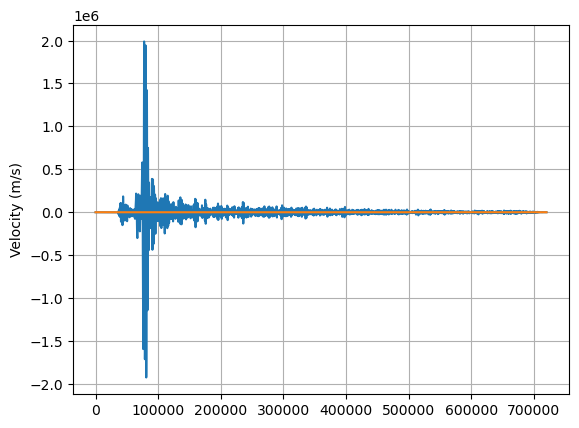

In [60]:
plt.plot(Z[0].data);plt.plot(N[0].data);plt.grid(True);plt.ylabel('Velocity (m/s)')



## 1. Fourier Transforms [**Level 1**]
We use the Scipy Fourier [package](!https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.rfft.html#scipy.fftpack.rfft) to transform the two time series (earthquake and noise).

The Fourier transform is a decomposition of the time series onto an orthonormal basis of cosine and sine functions. The Fourier transform of a time series $f(t)$ (but similarly if the variable is space $x$).

$\hat{F}(f) = \int_{-\infty}^\infty f(t) \exp^{-i2\pi ft} dt$

$\hat{F}(f)$ is the complex Fourier value at frequency $f$. The Fourier transform determines what frequency(ies) dominate the time series.



### 1.1 Nyquist
The Fourier transform we will use in this class takes a discrete time series of real numbers. The time series is sampled with $N$ samples per seconds. If the time series span $T$ seconds regularly, then the sampling rate of the data $dt=T/N$. The highest frequency that can be resolved in a discrete time series, called the Nyquist frequency, is limited by $dt$:

$F_{Nyq} = \frac{1}{2dt N}$

Effectively, one cannot constrain signals within two time samples from the data.

### 1.2 Uncertainties
* The discrete Fourier Transform yields an approximation of the FT. The shorter the time series, the least accurate is the FT. This means that the FT on short time windows is less accurate
* The FT assumes (and requires) the periodicity of the series, meaning that the finite/trimmed time series would repeat in time. To enforce this, we  **taper** the time series so that the first and last points are equal (to zero).


In [61]:
from scipy.fftpack import fft, ifft, fftfreq, next_fast_len

npts = Z[0].stats.npts
## FFT the signals
# fill up until 2^N value to speed up the FFT
Nfft = next_fast_len(int(Z[0].data.shape[0])) # this will be an even number
freqVec = fftfreq(Nfft, d=Z[0].stats.delta)[:Nfft//2]
Z.taper(max_percentage=0.05)
Zhat = fft(Z[0].data,n=Nfft)#/np.sqrt(Z[0].stats.npts)


Please see the Obspy documentation to find out about the [taper](!https://docs.obspy.org/master/packages/autogen/obspy.core.trace.Trace.taper.html#supported-methods) function.
Plot the amplitude and phase spectra

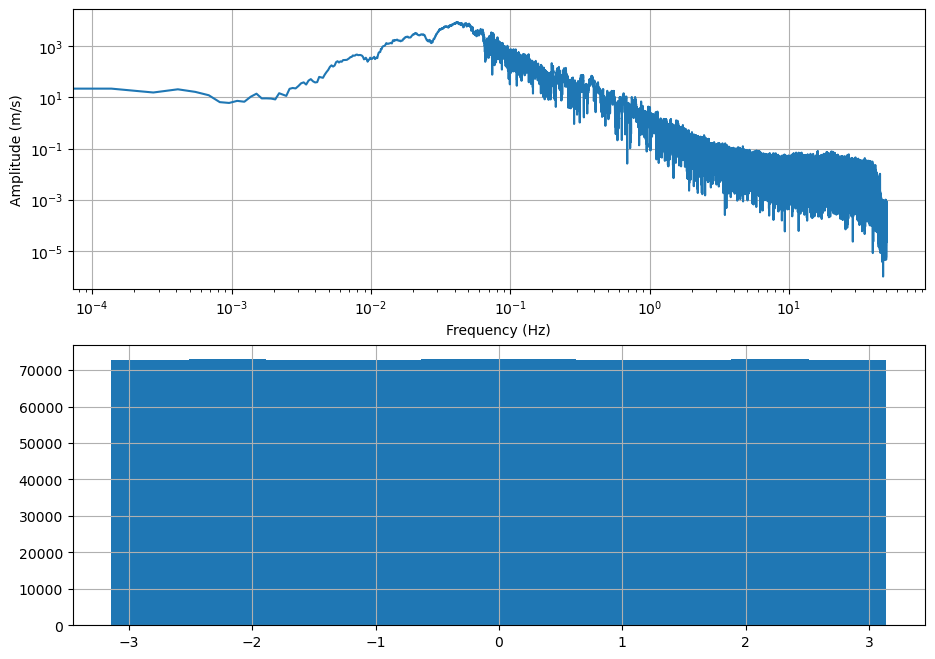

In [62]:
fig,ax=plt.subplots(2,1,figsize=(11,8))
ax[0].plot(freqVec,np.abs(Zhat[:Nfft//2])/Nfft)
ax[0].grid(True)
ax[0].set_xscale('log');ax[0].set_yscale('log')
ax[0].set_xlabel('Frequency (Hz)');ax[0].set_ylabel('Amplitude (m/s)')
ax[1].hist(np.angle(Zhat))
ax[1].grid(True)


You will note above that the phase values are randomly distributed between $-\pi$ and $\pi$. We can check it by showing the distribution of the phase and amplitude spectra.


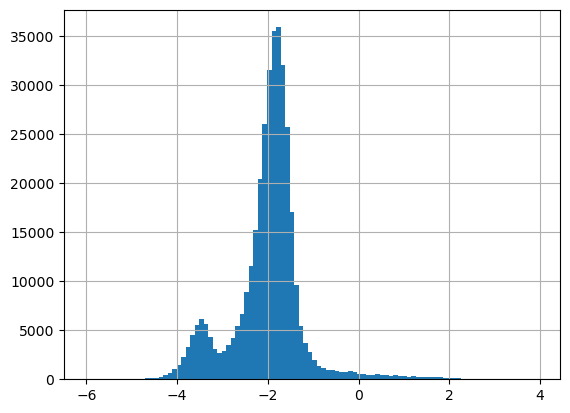

In [63]:
# your turn. Plot the histograms of the phase and amplitude spectrum
plt.hist(np.log10(np.abs(Zhat[:Nfft//2])/Nfft),100);plt.grid(True)
plt.show()

We can also analyze the spectral characteristics of the noise time series. Below, 
1. compute the Fourier transform
2. plot the phase and amplitude spectra
3. plot the distribution of the phase and amplitude values

In [64]:
# compute Fourier transform of the noise time series

npts1 = N[0].stats.npts
## FFT the signals
# fill up until 2^N value to speed up the FFT
Nfft1 = next_fast_len(int(N[0].data.shape[0])) # this will be an even number
freqVec1 = fftfreq(Nfft1, d=N[0].stats.delta)[:Nfft1//2]

# taper the data to enable periodicity
N.taper(max_percentage=0.05)

# Fourier transform
Nhat = fft(N[0].data,n=Nfft1)#/np.sqrt(Z[0].stats.npts)


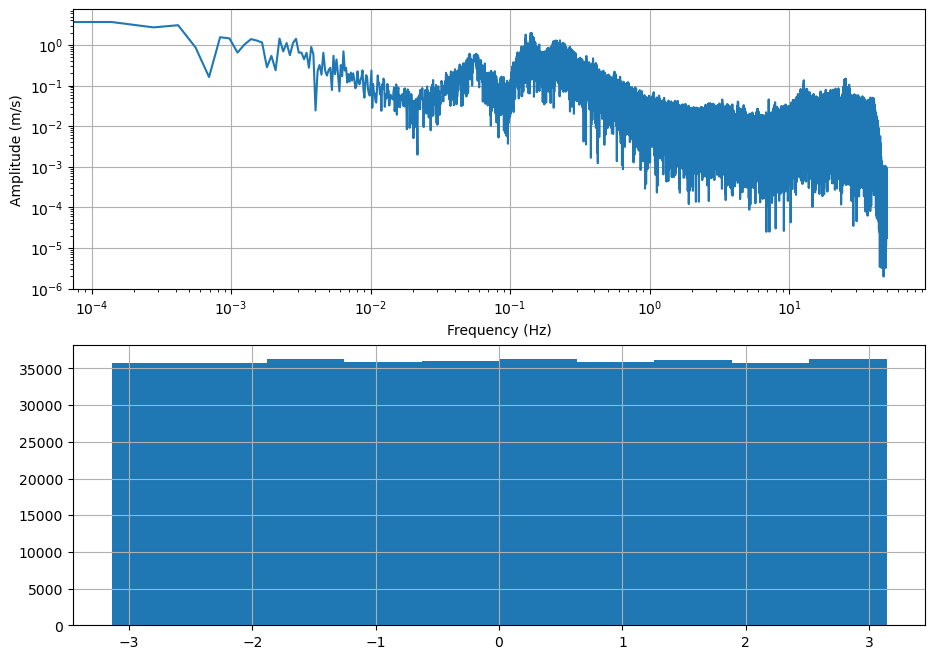

In [65]:
# plot the phase and amplitude spectra
fig,ax=plt.subplots(2,1,figsize=(11,8))
ax[0].plot(freqVec1,np.abs(Nhat[:Nfft1//2])/Nfft1)
ax[0].grid(True)
ax[0].set_xscale('log');ax[0].set_yscale('log')
ax[0].set_xlabel('Frequency (Hz)');ax[0].set_ylabel('Amplitude (m/s)')
ax[1].hist(np.angle(Nhat[:Nfft1//2]))
ax[1].grid(True)


(1e-05, 10000.0)

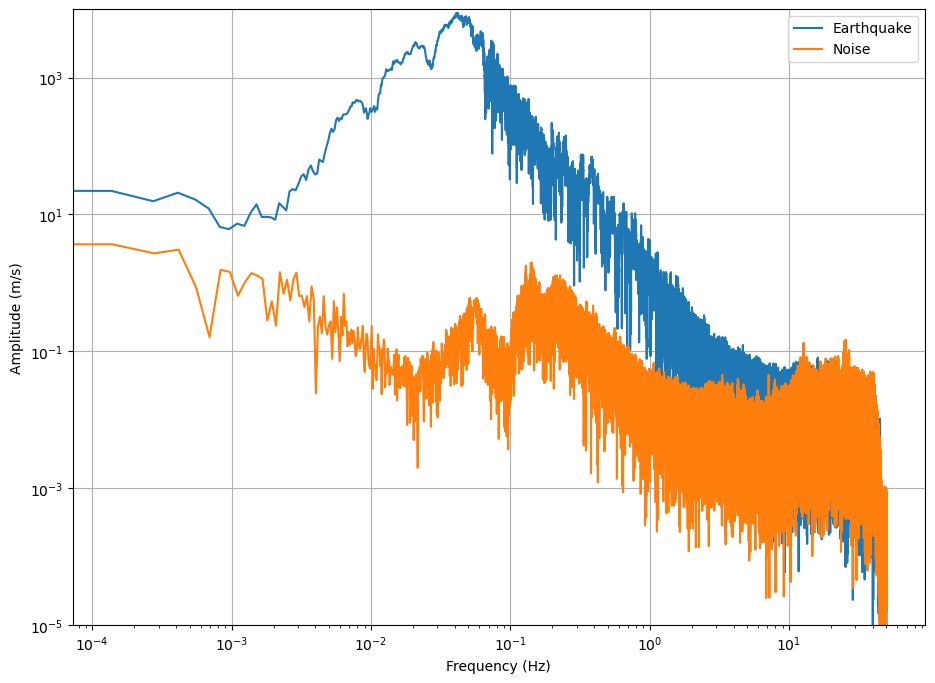

In [66]:
# Overlay the spectrum of the data and the spectrum of the noise

fig,ax=plt.subplots(1,1,figsize=(11,8))
ax.plot(freqVec,np.abs(Zhat[:Nfft//2])/Nfft)
ax.plot(freqVec1,np.abs(Nhat[:Nfft1//2])/Nfft1)
ax.grid(True)
ax.set_xscale('log');ax.set_yscale('log')
ax.set_xlabel('Frequency (Hz)');ax.set_ylabel('Amplitude (m/s)')
ax.legend(['Earthquake','Noise'])
ax.set_ylim([1e-5,1e4])


Overlay their PDFs

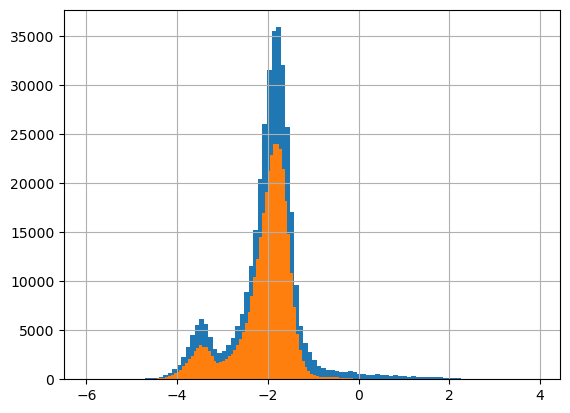

In [67]:
# your turn. Plot the histograms of the phase and amplitude spectrum
plt.hist(np.log10(np.abs(Zhat[:Nfft//2])/Nfft),100)
plt.hist(np.log10(np.abs(Nhat[:Nfft1//2])/Nfft1),100)
plt.grid(True)
plt.show()

You notice that their statistical differences are in the tails of the distributions. Therefore, statistical metrics such as ``mean`` or ``variance`` may not be discriminatory, but ``kurtosis`` might.

In [68]:
# print short float values
print(f"Skewness of earthquake {scipy.stats.skew(np.log10(np.abs(Zhat[:Nfft//2])))} and noise {scipy.stats.skew(np.log10(np.abs(Nhat[:Nfft1//2])))}")

print(f"Kurtosis of earthquake {scipy.stats.kurtosis(np.log10(np.abs(Zhat[:Nfft//2])))} and noise {scipy.stats.kurtosis(np.log10(np.abs(Nhat[:Nfft1//2])))}")

print(f"Mean of earthquake {np.mean(np.log10(np.abs(Zhat[:Nfft//2])))} and noise {np.mean(np.log10(np.abs(Nhat[:Nfft1//2])))}")

print(f"standard deviation of earthquakes {np.std(np.log10(np.abs(Zhat[:Nfft//2])))} and noise {np.std(np.log10(np.abs(Nhat[:Nfft1//2])))}")

Skewness of earthquake 0.8453316591147472 and noise -1.2201005948153736
Kurtosis of earthquake 6.236217054080996 and noise 1.6480666066247602
Mean of earthquake 3.8679961043240616 and noise 3.7679436013699075
standard deviation of earthquakes 0.8309308755378132 and noise 0.6173489951795071


## 2. 2D Fourier Transforms 

The 2D Fourier transform is applied on a 2D matrix. It first applies a 1D Fourier transform to every row of the matrix, then applies a 1D Fourier transform to every column of the intermediate matrix.

2D Fourier transforms can be used to find the Fourier coefficients that dominate the image. This can be used for filtering the data. Another application is to compress the data by selecting several coefficients instead of presenting most of the image.

We will practice on a DEM.

In [69]:
!pip install wget
import wget
import os
import netCDF4 as nc



[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [70]:
# Download the geological framework
file1 = wget.download("https://www.dropbox.com/s/wdb25puxh3u07dj/NCM_GeologicFrameworkGrids.nc?dl=1") #"./data/NCM_GeologicFrameworkGrids.nc"
# Download the coordinate grids
file2 = wget.download("https://www.dropbox.com/s/i6tv3ug15oe6yhe/NCM_SpatialGrid.nc?dl=1") #"./data/NCM_GeologicFrameworkGrids.nc"

In [71]:
# read data
geology = nc.Dataset(file1)
grid = nc.Dataset(file2)

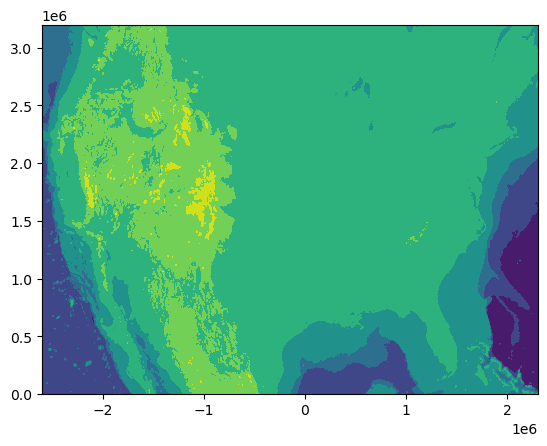

In [72]:
# create a grid of latitude and longitude
x = grid['x'][0:4901, 0:3201]
y = grid['y'][0:4901, 0:3201]
elevation = geology['Surface Elevation'][0:4901, 0:3201]
plt.contourf(x, y, elevation)

# recreate the lat long vectors.
minlat,maxlat = min(grid['Latitude vector'][:]),max(grid['Latitude vector'][:])
minlon,maxlon = min(grid['Longitude vector'][:]),max(grid['Longitude vector'][:])
xlat = np.linspace(minlat,maxlat,3201)
xlon = np.linspace(minlon,maxlon,4901)

Consider ``elevation`` as a 2D data set. We can perform a 2D transform, which will give us a spectrum in the spatial dimension.

this is about the spatial sampling of the model  1.5007397612756534  km
this is about the spatial sampling of the model  1.0777344413103096  km


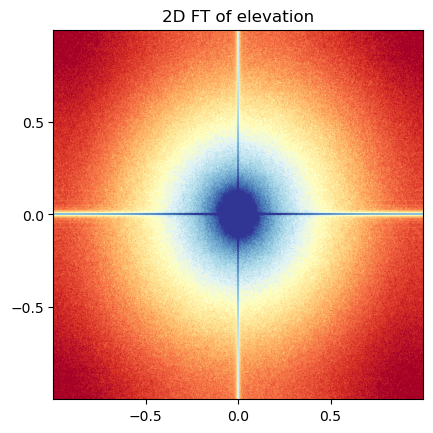

In [73]:
from scipy.fftpack import fft2, fftfreq,fftshift, ifft2
import matplotlib.cm as cm
Zel = fft2(elevation)



# make a vector of distances. Here I will ignore the curvature and spatial projection.
# make the wavenumber frequency vector: 
Rlon = (xlon-np.min(xlon))*111.25  # convert degrees to kms
drlon = Rlon[1]-Rlon[0]
print("this is about the spatial sampling of the model ",drlon," km")
klon = (fftfreq( 4901//2 , drlon  ))


Rlat = (xlat-np.min(xlat))*111.25  # convert degrees to kms
drlat = Rlat[1]-Rlat[0]
print("this is about the spatial sampling of the model ",drlat," km")
klat = (fftfreq( 3201//2 , drlat  ))

# amplitude of the DEM
plt.imshow(fftshift(np.log10(np.abs(Zel)/Zel.size)),vmin=-3, vmax=-1, cmap='RdYlBu',extent=[-1,1,-1,1])
plt.title('2D FT of elevation')
x_label_list = ['-1/3 km$^{-1}$','0','1/3  km$^{-1}$']
plt.xticks([-0.5,0,0.5])
plt.yticks([-0.5,0,0.5])
plt.show()

Now we will filter or compress by taking the largest Fourier coefficients of the image.

In [74]:
# Sort the Fourier coefficients
Zsort = np.sort(np.abs(np.abs(Zel).reshape(-1)))

In [75]:
print(len(Zsort))
print(Zsort.shape)

15688101
(15688101,)


We are keeping up to 0.010000 the number of Fourier coefficients


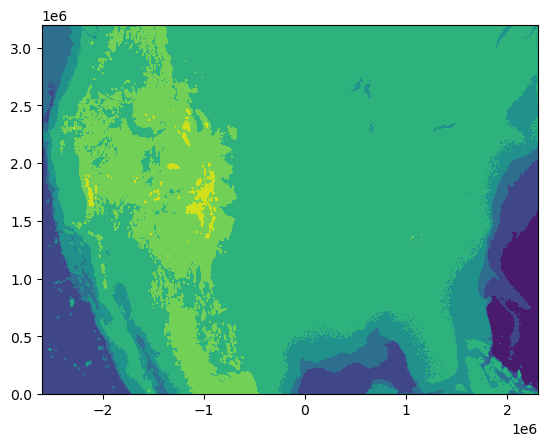

In [76]:
from IPython import display
import time
for keep in (0.1,0.05,0.01):
    display.clear_output(wait=True)
    thresh = Zsort[int(np.floor( (1-keep)*len(Zsort) ))]
    ind = np.abs(Zel)>thresh
    Atlow = Zel * ind # here we zero out the matrix
    # Here we count the number of non-zeros in the matrix
    print("We are keeping up to %f the number of Fourier coefficients" % keep)
    Alow = ifft2(Atlow).real
    plt.contourf(x, y, Alow)
    time.sleep(1)

Now we will compare the original 2D data set with the Fourier compressed data


We are keeping up to 0.010000 the number of Fourier coefficients


(-2600000.0, 2300000.0, 0.0, 3200000.0)

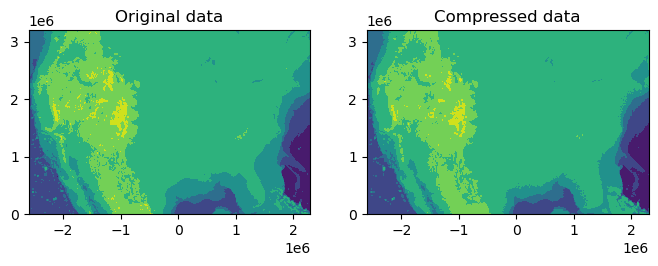

In [77]:
keep=0.01
thresh = Zsort[int(np.floor( (1-keep)*len(Zsort) ))]
ind = np.abs(Zel)>thresh
Atlow = Zel * ind # here we zero out the matrix
# Here we count the number of non-zeros in the matrix
print("We are keeping up to %f the number of Fourier coefficients" % keep)
Alow = ifft2(Atlow).real


fig,ax=plt.subplots(1,2,figsize=(8,8),sharex=True)
ax[0].contourf(x, y, elevation);ax[0].set_title('Original data')
ax[0].axis('scaled')
ax[1].contourf(x, y, Alow);ax[1].set_title('Compressed data')
ax[1].axis('scaled')

## 3. Spectrograms 


In time-dependent and multi-scale problems, it may be interesting to extract data features from the short time Fourier transform.

The STFT is a Fourier Transform applied to short (overlapping) windows to resolve the frequencies over different times in the series.

1767563.2884356107
47.86349029869899


/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_82861/1691094658.py:8: RuntimeWarning: divide by zero encountered in log10
  ax[0].pcolormesh(t/3600, f, np.log10(np.abs(Zxx)), vmin=-1, vmax=3.5, shading='gouraud')


(0.1, 40)

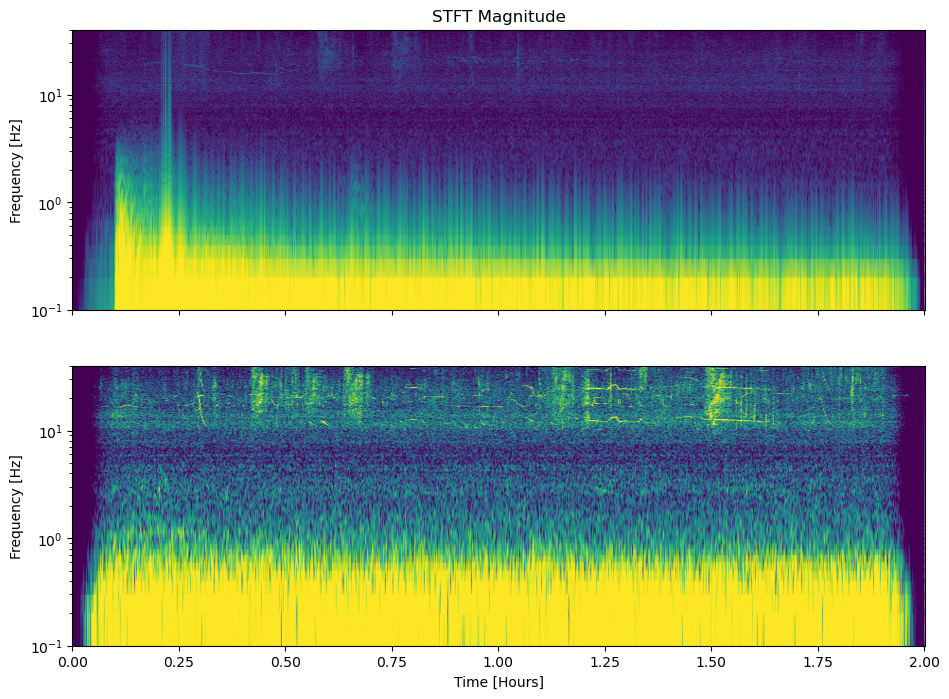

In [78]:
from scipy.signal import stft

nperseg=1000
z=np.asarray(Z[0].data)
f, t, Zxx = stft(z, fs=100, nperseg=nperseg,noverlap=200)
print(np.max(np.max(np.abs(Zxx))))
fig,ax=plt.subplots(2,1,figsize=(11,8),sharex=True)
ax[0].pcolormesh(t/3600, f, np.log10(np.abs(Zxx)), vmin=-1, vmax=3.5, shading='gouraud')
ax[0].set_title('STFT Magnitude')
ax[0].set_ylabel('Frequency [Hz]')
# ax[0].set_xlabel('Time [Hours]')
ax[0].set_yscale('log');ax[0].set_ylim(0.1,40)


n=np.asarray(N[0].data)
f, t, Zxx = stft(n, fs=100, nperseg=nperseg,noverlap=200)
print(np.max(np.max(np.abs(Zxx))))
ax[1].pcolormesh(t/3600, f, np.log10(np.abs(Zxx)), vmin=-1, vmax=0.5, shading='gouraud')
# ax[1].set_title('Noise Magnitude')
ax[1].set_ylabel('Frequency [Hz]')
ax[1].set_xlabel('Time [Hours]');ax[1].set_yscale('log');ax[1].set_ylim(0.1,40)

The spectrogram ``Zxx`` is a transform of the original data. It is common to use spectrograms as input to neural networks as 2D arrays.

In [79]:
Zxx.shape

(501, 901)

## 4. Continuous Wavelet Transform

### Introduction
The **Continuous Wavelet Transform (CWT)** is an important tool in geoscientific data analysis, particularly for time-frequency analysis of non-stationary signals. Like the spectrogram, the CWT provides insight into how the frequency content of a signal varies over time. However, the CWT offers better resolution at different frequencies, making it more suitable for analyzing signals with transient or localized frequency changes.


The **wavelet transform** breaks a signal down into scaled and shifted versions of a small, oscillating function known as the **wavelet**. This makes the CWT well-suited for geoscientific applications, where many phenomena, such as earthquakes, volcanic eruptions, and weather patterns, can manifest at different scales and frequencies.

![Fourier and Wavelet](../img/Wavelet-Out1.jpeg)

**Figure:** Fourier and wavelet basis functions. Image from this [article](!https://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/).

There exist many canonical wavelet families. The difference between families is typically their shape, compactness, and smoothness. Typically, one chooses one family for the specific time series. Wavelets have finite energy and zero mean.

![Wavelets](../img/wavelet_families.png)

**Figure**: Families of wavelet basis functions. Image from this [article](!https://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/)

The wavelet transform becomes:

$\hat{F}(a,b) = \frac{1}{\sqrt{a}} \int_{-\infty}^\infty f(t) \bar{\Psi} (\frac{t-b}{a}) dt$

where $\bar{\Psi}$ is the mother wavelet scaled by a factor of $a$ and translated/shifted by $b$. The wavelet transform is scaled by the continuous and "infinite number of values" of $a$ and $b$ are continuous. The *Discrete Wavelet Transform* is the wavelet transform performed on a finite number of scales and shifts.

The time-scale representation of a time series is a *scaleogram*. *scales* can be converted to pseudo frequencies: If $f_c$ is the central frequency of the wavelet and the scale is $a$, then the pseuo-frequency is $f_a = f_c/a$.


### Why Continuous Wavelet Transforms are Important
- **Multiresolution Analysis**: The CWT captures both low-frequency, long-duration trends and high-frequency, short-duration features. This is particularly valuable in geosciences, where processes occur on different temporal and spatial scales.
- **Non-Stationary Data**: Many geoscientific signals are non-stationary, meaning their statistical properties change over time. The CWT excels at revealing these time-varying frequency components.
- **Local Feature Detection**: CWT is excellent for identifying localized events, such as seismic waves, landslides, or atmospheric disturbances, by analyzing how the signal changes in both time and frequency.
- **Better Time-Frequency Resolution**: The wavelet transform provides more precise time and frequency localization than methods like the Fourier transform or spectrogram, especially for short-lived events.

### Use in Seismology
In seismic data, different types of seismic waves (P-waves, S-waves, and surface waves) occur at different frequencies and durations. By applying CWT, seismologists can detect these different wave phases and their precise arrival times, which are critical for earthquake characterization.

### Python Example: Continuous Wavelet Transform of Seismic Data

Below is a Python code example to generate and visualize a continuous wavelet transform using seismic data.


In [80]:
!pip install pycwt


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [81]:
import numpy as np
import matplotlib.pyplot as plt
import pycwt
import obspy

# Load a sample seismic data using the obspy library
from obspy import read

# Load the data
st = read()  # Load a demo seismogram from obspy's example data
tr = st[0]   # Select the first trace

# Extract the data and sampling rate
data = tr.data
sampling_rate = tr.stats.sampling_rate

# Define scales and wavelet
scales = np.arange(1, 128)  # Range of scales for CWT
wavelet = 'cmor'  # Complex Morlet wavelet, commonly used for seismic data

# Compute the Continuous Wavelet Transform (CWT)
coefficients, frequencies = pycwt.cwt(data, scales, wavelet, dt=1/sampling_rate)

# Plot the wavelet transform
plt.figure(figsize=(10, 6))
plt.imshow(np.abs(coefficients), extent=[0, tr.stats.endtime - tr.stats.starttime, 1, 128],
           cmap='jet', aspect='auto', vmax=0.01)
plt.colorbar(label='Magnitude')
plt.ylabel('Scale')
plt.xlabel('Time [s]')
plt.title('Continuous Wavelet Transform (CWT) of Seismic Signal')
plt.show()


TypeError: cwt() got multiple values for argument 'dt'

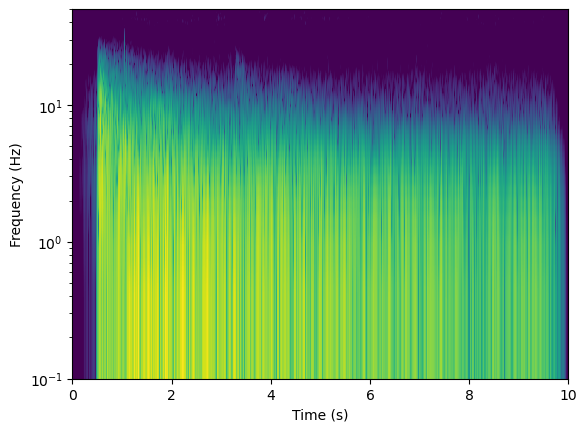

In [57]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

# Assuming Z and z are already defined
# Z: list of objects with .stats.delta attribute
# z: 1D array of the signal

# Define time vector and sampling frequency
Tstart = 0  # Define Tstart appropriately
Tend = 10  # Define Tend appropriately
t = np.arange(0, (Tend - Tstart) + Z[0].stats.delta, Z[0].stats.delta)  # time vector
fs = 1 / Z[0].stats.delta  # sampling frequency

# Number of scales to use
w = 6.0

# Relate scales with frequencies
freq = np.logspace(-1, np.log10(fs / 2), 100)
widths = w * fs / (2 * freq * np.pi)

# Compute the CWT
cwtm = signal.cwt(z, signal.morlet2, widths, w=w)
v1 = np.log10(np.abs(cwtm)).min()
v2 = np.log10(np.abs(cwtm)).max()
# Plot the CWT coefficients
plt.imshow(np.log10(np.abs(cwtm)), extent=[t.min(), t.max(), freq.min(), freq.max()], cmap='viridis', aspect='auto',
           vmin=v2-5, vmax=v2, origin='lower')
plt.yscale('log')
plt.ylim([freq.min(), freq.max()])

# Add x-axis label
plt.xlabel('Time (s)')

# Add y-axis label
plt.ylabel('Frequency (Hz)')

# Show the plot
plt.show()

In [43]:
import scipy.signal as signal


t = np.arange(0,(Tend-Tstart)+Z[0].stats.delta,Z[0].stats.delta) # time vector
fs=1/Z[0].stats.delta # sampling frequency

# number of scales to use
w = 6.

# relate scales with frequencies
freq = np.logspace(-1, np.log10(fs/2), 100)
widths = w*fs / (2*freq*np.pi)


cwtm = signal.cwt(z, signal.morlet2, widths, w=w)

Calculating the time-frequency representation of large time series 

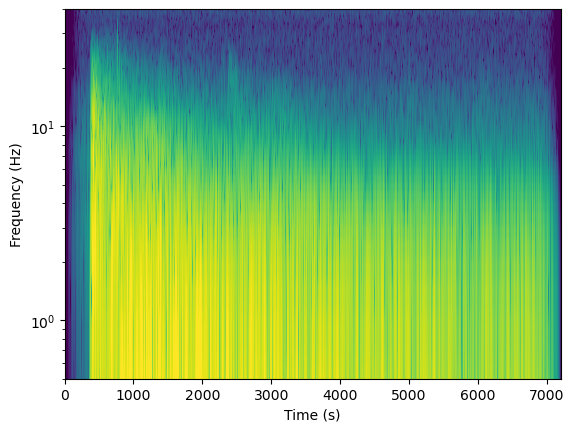

In [45]:

# cwtmatr = signal.cwt(z, signal.morlet, widths)
plt.imshow(np.log10(np.abs(cwtm)), extent=[t.min(),t.max(),freq.min(),freq.max()], cmap='viridis', aspect='auto',
           vmax=6, vmin=-0.5,origin='lower')
plt.yscale('log')
plt.ylim([0.5,40])


# Add x-axis label
plt.xlabel('Time (s)')  # Replace 'Time (s)' with the appropriate label for your data

# Add y-axis label
plt.ylabel('Frequency (Hz)')  # Replace 'Frequency (Hz)' with the appropriate label for your data


plt.show()


#### Advantages of CWT in Geosciences:
- **Time-Localized Event Detection**: CWT is excellent at identifying short-lived geophysical events, such as the arrival of seismic waves during an earthquake.
- **Multiscale Phenomena**: Natural processes like tectonic activity and oceanic tides operate over a broad range of temporal and spatial scales. CWT can effectively analyze signals from these processes by using a wide range of scales.
- **Edge Detection**: The wavelet transform is particularly good at detecting changes or discontinuities in signals, such as the sharp onset of seismic waves or the boundaries of different geophysical layers.
  
#### Use Cases in Geoscience:
- **Earthquake Early Warning**: By applying CWT, geoscientists can more accurately detect the first arrival of seismic waves, which is critical for early warning systems.
- **Landslide Detection**: The CWT helps in identifying high-frequency signals indicative of landslides, as these events are often characterized by short bursts of energy.
- **Volcanic Tremors**: CWT can be used to analyze volcanic tremor signals, which are often complex and exhibit both short and long-duration features.

#### Conclusion
The Continuous Wavelet Transform (CWT) is a powerful tool for time-frequency analysis in geosciences. Its ability to resolve signals across different scales and frequencies makes it highly suitable for studying non-stationary processes. By using Python libraries like `pywt`, `obspy`, and `matplotlib`, geoscientists can effectively apply CWT to their data to extract insights into complex geophysical phenomena.

TF transforms take computational time in the workflow, let's compare:

In [30]:
%timeit cwtm = signal.cwt(z, signal.morlet2, widths, w=w)
%timeit f, t, Zxx = stft(n, fs=100, nperseg=nperseg,noverlap=200)


5.68 s ± 39.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5.49 ms ± 224 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


From these transform, we can extract similar statistical features